# Example notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pertpy
from deres import DEResult
import scanpy as sc
import numpy as np
import pandas as pd

/home/sturm/projects/scverse/deres/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
adata = sc.datasets.pbmc3k_processed()

In [4]:
adata.obs["sample"] = pd.Categorical(np.random.randint(0, 10, adata.shape[0]))
adata = sc.AnnData(adata.raw.X, obs=adata.obs, var=adata.raw.var)

In [5]:
adata.obs

,n_genes,percent_mito,n_counts,louvain,sample
index,,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells,6
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,5
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells,1
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,0
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells,9
...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0,CD14+ Monocytes,5
TTTCTACTGAGGCA-1,1227,0.009294,3443.0,B cells,7
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B cells,9


In [6]:
pb = sc.get.aggregate(adata, ["sample", "louvain"], "mean")

In [7]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'sample'
    var: 'n_cells'

In [8]:
pb.layers["mean"]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.01624564,
        0.01624564],
       [0.        , 0.        , 0.        , ..., 0.        , 0.03713288,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02888113, 0.02888113,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.04951051,
        0.        ],
       [0.        , 0.        , 0.1732868 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [9]:
mod = pertpy.tl.Statsmodels(pb, design="~ louvain", layer="mean")
mod.fit()

100%|██████████| 13714/13714 [00:11<00:00, 1206.84it/s]


In [10]:
res = mod.test_contrasts({"CD8_vs_CD4": mod.cond(louvain="CD8 T cells") - mod.cond(louvain="CD4 T cells")})
res["p_value"] = res["p_value"].astype(float) # don't ask me why this is an object column

100%|██████████| 13714/13714 [00:01<00:00, 12014.11it/s]


In [11]:
res

,variable,p_value,t_value,sd,log_fc,adj_p_value,contrast
13001,NKG7,1.839784e-42,3.082804e+01,0.057218,1.763930e+00,1.839784e-42,CD8_vs_CD4
11083,CCL5,1.195866e-36,2.502877e+01,0.071763,1.796151e+00,1.195866e-36,CD8_vs_CD4
3694,GZMK,3.894295e-33,2.197642e+01,0.032957,7.242777e-01,3.894295e-33,CD8_vs_CD4
3695,GZMA,3.581829e-32,2.119109e+01,0.038872,8.237365e-01,3.581829e-32,CD8_vs_CD4
11879,CST7,1.263746e-29,1.921307e+01,0.045090,8.663255e-01,1.263746e-29,CD8_vs_CD4
...,...,...,...,...,...,...,...
10703,ZNF778,1.000000e+00,8.128430e-17,0.018472,1.501461e-18,1.000000e+00,CD8_vs_CD4
12738,CTD-2540F13.2,1.000000e+00,9.990179e-17,0.001488,1.486824e-19,1.000000e+00,CD8_vs_CD4
11454,SMIM5,1.000000e+00,-4.080746e-17,0.048560,-1.981628e-18,1.000000e+00,CD8_vs_CD4
6978,RP11-138I18.2,1.000000e+00,-1.045136e-16,0.001615,-1.687526e-19,1.000000e+00,CD8_vs_CD4


In [36]:
de_res = DEResult(res, adata, p_col="p_value", effect_size_col="log_fc", var_col="variable", contrast_col="contrast")

In [31]:
de_res.p_adjust()

In [34]:
de_res.res["adj_p_value"].dtype

dtype('float64')

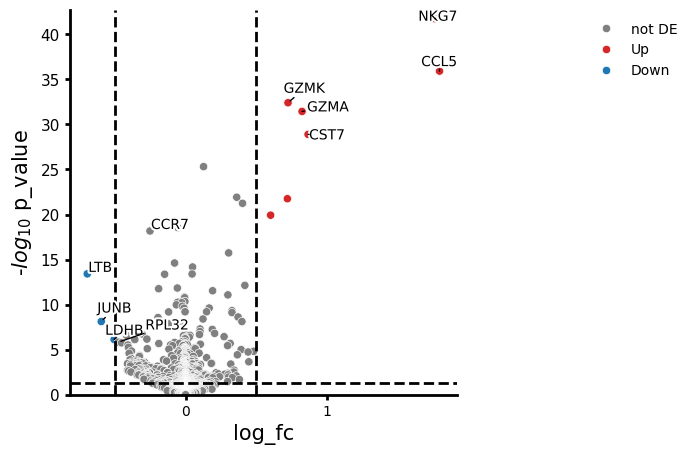

In [20]:
de_res.plot_volcano(log2fc_thresh=0.5)

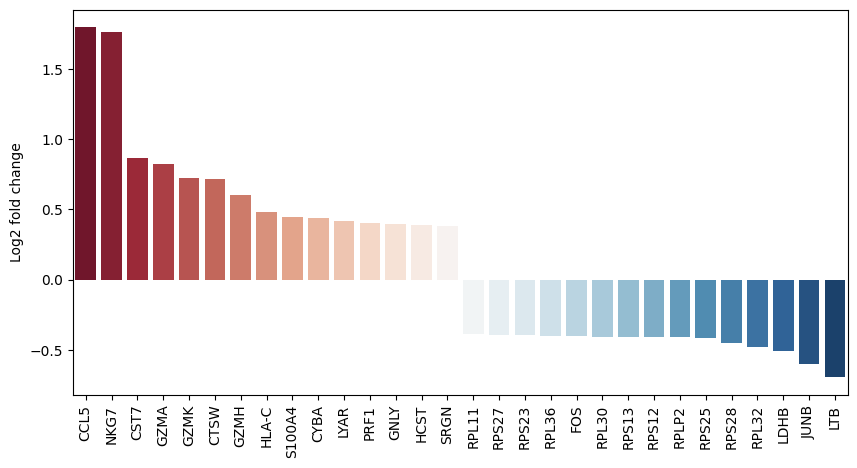

In [25]:
de_res.plot_fold_change()

In [21]:
de_res.plot_paired("louvain", "sample")

ValueError: The number of groups in the group_by column must be exactly 2 to enable paired testing